## Regression Tree, Random Forest and Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Charger les données
df = pd.read_csv('data/training_data_imputed.csv')

In [3]:
# Sélectionner les variables clés
key_features = ['PM2.5', 'PM10', 'O3', 'NO2', 'CO', 'WindSpeed', 
                'SO2', 'NOx', 'NO', 'O3_8hr', 'CO_8hr']

In [4]:
# Créer le dataset
data = df[key_features + ['AQI']].copy()

In [5]:
# Division train/test
X = data[key_features]
y = data['AQI']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [6]:
print("=" * 70)
print("TREE-BASED METHODS : Style ISLP")
print("=" * 70)
print(f"\nTaille d'entraînement: {X_train.shape}")
print(f"Taille de test: {X_test.shape}")
print(f"Variables utilisées: {len(key_features)}\n")

# Stockage des résultats
results = []

TREE-BASED METHODS : Style ISLP

Taille d'entraînement: (56633, 11)
Taille de test: (14159, 11)
Variables utilisées: 11



In [7]:
# ====================================================================
# 1. REGRESSION TREES
# ====================================================================

print("=" * 70)
print("1. REGRESSION TREES")
print("=" * 70)

1. REGRESSION TREES


In [8]:
# 1.1 Arbre complet (unpruned)
print("\n1.1 Arbre complet (unpruned)")
tree_full = DecisionTreeRegressor(random_state=1)
tree_full.fit(X_train, y_train)

# Prédictions
y_train_pred = tree_full.predict(X_train)
y_test_pred = tree_full.predict(X_test)

# Erreurs
mse_train_full = mean_squared_error(y_train, y_train_pred)
mse_test_full = mean_squared_error(y_test, y_test_pred)


1.1 Arbre complet (unpruned)


In [9]:
print(f"  Nombre de feuilles: {tree_full.get_n_leaves()}")
print(f"  Profondeur: {tree_full.get_depth()}")
print(f"  MSE Train: {mse_train_full:.4f}")
print(f"  MSE Test:  {mse_test_full:.4f}")

  Nombre de feuilles: 51084
  Profondeur: 38
  MSE Train: 0.0000
  MSE Test:  315.8875


In [10]:
# 1.2 Pruning: Tester différentes profondeurs max
print("\n1.2 Cost Complexity Pruning")

# Obtenir le chemin de complexité
path = tree_full.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print(f"  Nombre de alphas: {len(ccp_alphas)}")

# Limiter le nombre d'alphas pour éviter le surapprentissage
ccp_alphas = ccp_alphas[::len(ccp_alphas)//20]  # Prendre ~20 valeurs

# Entraîner des arbres pour chaque alpha
train_scores = []
test_scores = []
n_leaves = []

for alpha in ccp_alphas:
    tree = DecisionTreeRegressor(random_state=1, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    
    train_scores.append(mean_squared_error(y_train, tree.predict(X_train)))
    test_scores.append(mean_squared_error(y_test, tree.predict(X_test)))
    n_leaves.append(tree.get_n_leaves())

# Meilleur alpha
best_idx = np.argmin(test_scores)
best_alpha = ccp_alphas[best_idx]

print(f"\n  Alpha optimal: {best_alpha:.6f}")
print(f"  MSE Test optimal: {test_scores[best_idx]:.4f}")
print(f"  Nombre de feuilles: {n_leaves[best_idx]}")


1.2 Cost Complexity Pruning
  Nombre de alphas: 46188

  Alpha optimal: 0.012384
  MSE Test optimal: 241.8098
  Nombre de feuilles: 3674


In [11]:
# Ajuster l'arbre optimal
tree_pruned = DecisionTreeRegressor(random_state=1, ccp_alpha=best_alpha)
tree_pruned.fit(X_train, y_train)
y_pred_tree = tree_pruned.predict(X_test)

results.append({
    'Méthode': f'Regression Tree (pruned)',
    'MSE Train': mean_squared_error(y_train, tree_pruned.predict(X_train)),
    'MSE Test': test_scores[best_idx],
    'RMSE Test': np.sqrt(test_scores[best_idx])
})

# Variable importance
feature_importance = pd.DataFrame({
    'Variable': key_features,
    'Importance': tree_pruned.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n  Top 5 variables importantes:")


  Top 5 variables importantes:


In [12]:
print("\n  Top 5 variables importantes:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"    {row['Variable']}: {row['Importance']:.4f}")


  Top 5 variables importantes:
    PM2.5: 0.8348
    O3_8hr: 0.0588
    PM10: 0.0332
    CO_8hr: 0.0128
    CO: 0.0114


### BAGGING

In [13]:
print("\n" + "=" * 70)
print("2. BAGGING")
print("=" * 70)

# Bagging = Random Forest avec max_features = p (toutes les variables)
# Tester différents nombres d'arbres
n_trees_list = [10, 50, 100, 200, 500]
bagging_mse_test = []

print("\nTesting different numbers of trees...")
for n_trees in n_trees_list:
    # max_features=None utilise toutes les features (= Bagging)
    rf = RandomForestRegressor(n_estimators=n_trees, 
                                max_features=None,
                                random_state=1)
    rf.fit(X_train, y_train)
    
    y_test_pred = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    bagging_mse_test.append(mse_test)
    
    print(f"  n_trees={n_trees:3d}: MSE Test = {mse_test:.4f}")


2. BAGGING

Testing different numbers of trees...
  n_trees= 10: MSE Test = 171.2346
  n_trees= 50: MSE Test = 159.0321
  n_trees=100: MSE Test = 157.6187
  n_trees=200: MSE Test = 157.2776
  n_trees=500: MSE Test = 156.9320


In [14]:
# Meilleur nombre d'arbres
best_n_trees_bag = n_trees_list[np.argmin(bagging_mse_test)]
print(f"\n→ Optimal: {best_n_trees_bag} arbres (MSE Test: {min(bagging_mse_test):.4f})")

# Ajuster le meilleur modèle
rf_bagging = RandomForestRegressor(n_estimators=best_n_trees_bag,
                                    max_features=None,
                                    random_state=1)
rf_bagging.fit(X_train, y_train)
y_pred_bagging = rf_bagging.predict(X_test)

results.append({
    'Méthode': f'Bagging (B={best_n_trees_bag})',
    'MSE Train': mean_squared_error(y_train, rf_bagging.predict(X_train)),
    'MSE Test': min(bagging_mse_test),
    'RMSE Test': np.sqrt(min(bagging_mse_test))
})


→ Optimal: 500 arbres (MSE Test: 156.9320)


### Random Forest

In [15]:
# ====================================================================
# 3. RANDOM FORESTS
# ====================================================================

print("\n" + "=" * 70)
print("3. RANDOM FORESTS")
print("=" * 70)

# 3.1 Tester différents max_features (m)
print("\n3.1 Optimisation de max_features (m)")

# Valeurs typiques: sqrt(p), p/3, p/2
p = len(key_features)
m_values = [int(np.sqrt(p)), p//3, p//2, p]
m_labels = ['sqrt(p)', 'p/3', 'p/2', 'p']

rf_mse_test = []

for m, label in zip(m_values, m_labels):
    rf = RandomForestRegressor(n_estimators=500, 
                                max_features=m,
                                random_state=1)
    rf.fit(X_train, y_train)
    
    y_test_pred = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rf_mse_test.append(mse_test)
    
    print(f"  m={m:2d} ({label:6s}): MSE Test = {mse_test:.4f}")

# Meilleur m
best_m_idx = np.argmin(rf_mse_test)
best_m = m_values[best_m_idx]
print(f"\n→ Optimal: m={best_m} (MSE Test: {rf_mse_test[best_m_idx]:.4f})")

# 3.2 Tester le nombre d'arbres avec le meilleur m
print(f"\n3.2 Optimisation du nombre d'arbres (B) avec m={best_m}")

n_trees_list_rf = [50, 100, 200, 300, 500, 1000]
rf_ntrees_mse_test = []


3. RANDOM FORESTS

3.1 Optimisation de max_features (m)
  m= 3 (sqrt(p)): MSE Test = 154.2325
  m= 3 (p/3   ): MSE Test = 154.2325
  m= 5 (p/2   ): MSE Test = 154.2998
  m=11 (p     ): MSE Test = 156.9320

→ Optimal: m=3 (MSE Test: 154.2325)

3.2 Optimisation du nombre d'arbres (B) avec m=3


2000


In [41]:
for n_trees in n_trees_list_rf:
    rf = RandomForestRegressor(n_estimators=n_trees,
                                max_features=best_m,
                                random_state=1)
    rf.fit(X_train, y_train)
    
    y_test_pred = rf.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rf_ntrees_mse_test.append(mse_test)
    
    print(f"  B={n_trees:4d}: MSE Test = {mse_test:.4f}")

  B=  50: MSE Test = 157.6697
  B= 100: MSE Test = 155.9251
  B= 200: MSE Test = 154.7931
  B= 300: MSE Test = 154.4789
  B= 500: MSE Test = 154.2325


KeyboardInterrupt: 

In [44]:
# Meilleur nombre d'arbres
best_n_trees_rf = n_trees_list_rf[np.argmin(rf_ntrees_mse_test)]
print(f"\n→ Optimal: B={best_n_trees_rf} (MSE Test: {min(rf_ntrees_mse_test):.4f})")



→ Optimal: B=1000 (MSE Test: 153.9998)


In [45]:
# Ajuster le meilleur Random Forest
rf_best = RandomForestRegressor(n_estimators=best_n_trees_rf,
                                 max_features=best_m,
                                 random_state=1)

In [46]:
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)


KeyboardInterrupt: 

In [ ]:
results.append({
    'Méthode': f'Random Forest (B={best_n_trees_rf}, m={best_m})',
    'MSE Train': mean_squared_error(y_train, rf_best.predict(X_train)),
    'MSE Test': min(rf_ntrees_mse_test),
    'RMSE Test': np.sqrt(min(rf_ntrees_mse_test))
})

In [ ]:
# Variable importance
rf_importance = pd.DataFrame({
    'Variable': key_features,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False)


In [ ]:
print("\n  Top 5 variables importantes:")
for idx, row in rf_importance.head(5).iterrows():
    print(f"    {row['Variable']}: {row['Importance']:.4f}")

## Boosting 

In [20]:
print("\n" + "=" * 70)
print("4. BOOSTING (Gradient Boosting)")
print("=" * 70)

# 4.1 Tester différentes profondeurs d'arbres
print("\n4.1 Optimisation de la profondeur (max_depth)")

depths = [1, 2, 3, 4, 5]
boost_depth_mse_test = []


4. BOOSTING (Gradient Boosting)

4.1 Optimisation de la profondeur (max_depth)


In [21]:
for depth in depths:
    gbm = GradientBoostingRegressor(n_estimators=500,
                                     max_depth=depth,
                                     learning_rate=0.01,
                                     random_state=1)
    gbm.fit(X_train, y_train)
    
    y_test_pred = gbm.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    boost_depth_mse_test.append(mse_test)
    
    print(f"  depth={depth}: MSE Test = {mse_test:.4f}")


  depth=1: MSE Test = 227.2746
  depth=2: MSE Test = 183.3081
  depth=3: MSE Test = 168.7318
  depth=4: MSE Test = 161.5213
  depth=5: MSE Test = 155.7649


In [22]:
# Meilleure profondeur
best_depth = depths[np.argmin(boost_depth_mse_test)]
print(f"\n→ Optimal depth: {best_depth} (MSE Test: {min(boost_depth_mse_test):.4f})")


→ Optimal depth: 5 (MSE Test: 155.7649)


In [23]:
# 4.2 Tester différents learning rates
print(f"\n4.2 Optimisation du learning rate (λ) avec depth={best_depth}")

lambdas = [0.001, 0.01, 0.05, 0.1, 0.2]
boost_lambda_mse_test = []


4.2 Optimisation du learning rate (λ) avec depth=5


In [24]:
for lam in lambdas:
    gbm = GradientBoostingRegressor(n_estimators=500,
                                     max_depth=best_depth,
                                     learning_rate=lam,
                                     random_state=1)
    gbm.fit(X_train, y_train)
    
    y_test_pred = gbm.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    boost_lambda_mse_test.append(mse_test)
    
    print(f"  λ={lam:.3f}: MSE Test = {mse_test:.4f}")

  λ=0.001: MSE Test = 552.1339
  λ=0.010: MSE Test = 155.7649
  λ=0.050: MSE Test = 147.7466
  λ=0.100: MSE Test = 147.9732
  λ=0.200: MSE Test = 150.5352


In [25]:
# Meilleur learning rate
best_lambda = lambdas[np.argmin(boost_lambda_mse_test)]
print(f"\n→ Optimal λ: {best_lambda} (MSE Test: {min(boost_lambda_mse_test):.4f})")


→ Optimal λ: 0.05 (MSE Test: 147.7466)


In [26]:
# 4.3 Tester le nombre d'itérations avec les meilleurs paramètres
print(f"\n4.3 Optimisation de B avec depth={best_depth}, λ={best_lambda}")

n_trees_boost = [100, 200, 500, 1000, 2000]
boost_ntrees_mse_test = []
boost_train_errors = []


4.3 Optimisation de B avec depth=5, λ=0.05


In [27]:
for n_trees in n_trees_boost:
    gbm = GradientBoostingRegressor(n_estimators=n_trees,
                                     max_depth=best_depth,
                                     learning_rate=best_lambda,
                                     random_state=1)
    gbm.fit(X_train, y_train)
    
    y_train_pred = gbm.predict(X_train)
    y_test_pred = gbm.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    boost_train_errors.append(mse_train)
    boost_ntrees_mse_test.append(mse_test)
    
    print(f"  B={n_trees:4d}: MSE Train = {mse_train:.4f}, MSE Test = {mse_test:.4f}")


  B= 100: MSE Train = 141.9566, MSE Test = 155.6473
  B= 200: MSE Train = 132.6061, MSE Test = 150.0657
  B= 500: MSE Train = 122.5178, MSE Test = 147.7466
  B=1000: MSE Train = 111.2335, MSE Test = 147.8058
  B=2000: MSE Train = 95.0123, MSE Test = 149.1052


In [28]:
# Meilleur nombre d'arbres
best_n_trees_boost = n_trees_boost[np.argmin(boost_ntrees_mse_test)]
print(f"\n→ Optimal: B={best_n_trees_boost} (MSE Test: {min(boost_ntrees_mse_test):.4f})")


→ Optimal: B=500 (MSE Test: 147.7466)


In [29]:
# Ajuster le meilleur modèle de boosting
gbm_best = GradientBoostingRegressor(n_estimators=best_n_trees_boost,
                                      max_depth=best_depth,
                                      learning_rate=best_lambda,
                                      random_state=1)

In [30]:
gbm_best.fit(X_train, y_train)
y_pred_boost = gbm_best.predict(X_test)

results.append({
    'Méthode': f'Boosting (B={best_n_trees_boost}, d={best_depth}, λ={best_lambda})',
    'MSE Train': mean_squared_error(y_train, gbm_best.predict(X_train)),
    'MSE Test': min(boost_ntrees_mse_test),
    'RMSE Test': np.sqrt(min(boost_ntrees_mse_test))
})

In [31]:
# Variable importance
boost_importance = pd.DataFrame({
    'Variable': key_features,
    'Importance': gbm_best.feature_importances_
}).sort_values('Importance', ascending=False)

In [32]:
print("\n  Top 5 variables importantes:")
for idx, row in boost_importance.head(5).iterrows():
    print(f"    {row['Variable']}: {row['Importance']:.4f}")


  Top 5 variables importantes:
    PM2.5: 0.8504
    O3_8hr: 0.0569
    PM10: 0.0528
    CO_8hr: 0.0151
    CO: 0.0064


In [33]:
# ====================================================================
# 5. COMPARAISON DES MÉTHODES
# ====================================================================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MSE Test')

print("\n", results_df.to_string(index=False))


                       Méthode  MSE Train   MSE Test  RMSE Test
Boosting (B=500, d=5, λ=0.05) 122.517778 147.746611  12.155106
              Bagging (B=500)  20.712236 156.931969  12.527249
     Regression Tree (pruned)  75.653905 241.809792  15.550234


In [34]:
best_method = results_df.iloc[0]['Méthode']
best_mse = results_df.iloc[0]['MSE Test']
print(f"\n→ Meilleure méthode: {best_method}")
print(f"  MSE Test: {best_mse:.4f}")


→ Meilleure méthode: Boosting (B=500, d=5, λ=0.05)
  MSE Test: 147.7466


In [35]:
# Comparer avec l'arbre simple
improvement = (mse_test_full - best_mse) / mse_test_full * 100
print(f"  Amélioration vs arbre simple: {improvement:.2f}%")

  Amélioration vs arbre simple: 53.23%


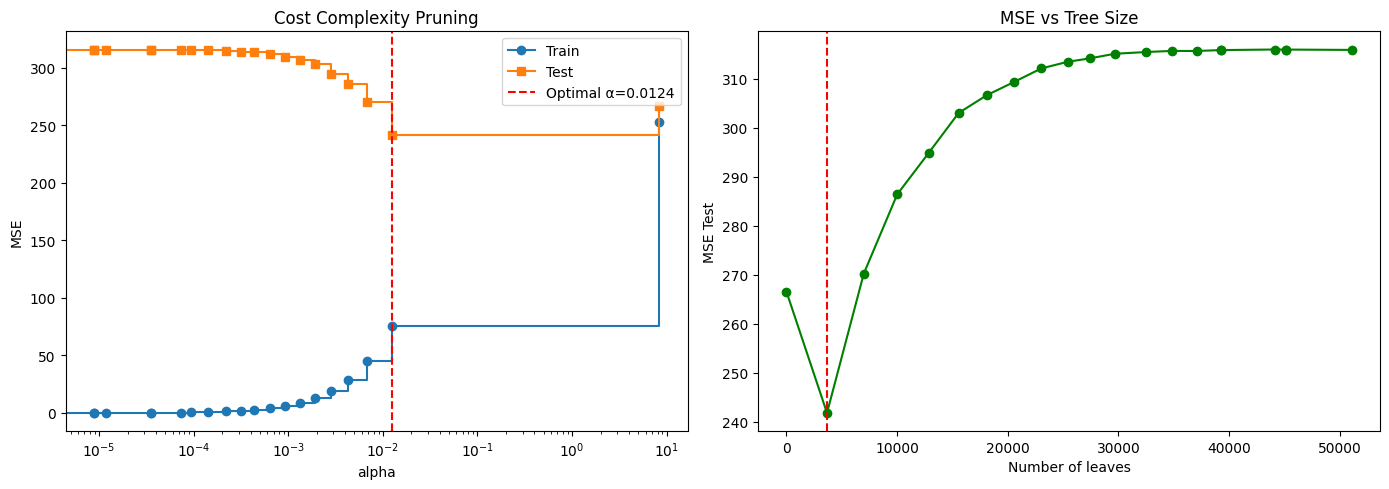

In [36]:
# ====================================================================
# 6. VISUALISATIONS (Style ISLP)
# ====================================================================

# Figure 1: Pruning du regression tree
fig, axes = subplots(1, 2, figsize=(14, 5))

axes[0].plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle='steps-post')
axes[0].plot(ccp_alphas, test_scores, marker='s', label='Test', drawstyle='steps-post')
axes[0].axvline(best_alpha, color='red', linestyle='--', label=f'Optimal α={best_alpha:.4f}')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('MSE')
axes[0].set_title('Cost Complexity Pruning')
axes[0].legend()
axes[0].set_xscale('log')

axes[1].plot(n_leaves, test_scores, marker='o', color='green')
axes[1].set_xlabel('Number of leaves')
axes[1].set_ylabel('MSE Test')
axes[1].set_title('MSE vs Tree Size')
axes[1].axvline(n_leaves[best_idx], color='red', linestyle='--')

fig.tight_layout()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (11,)

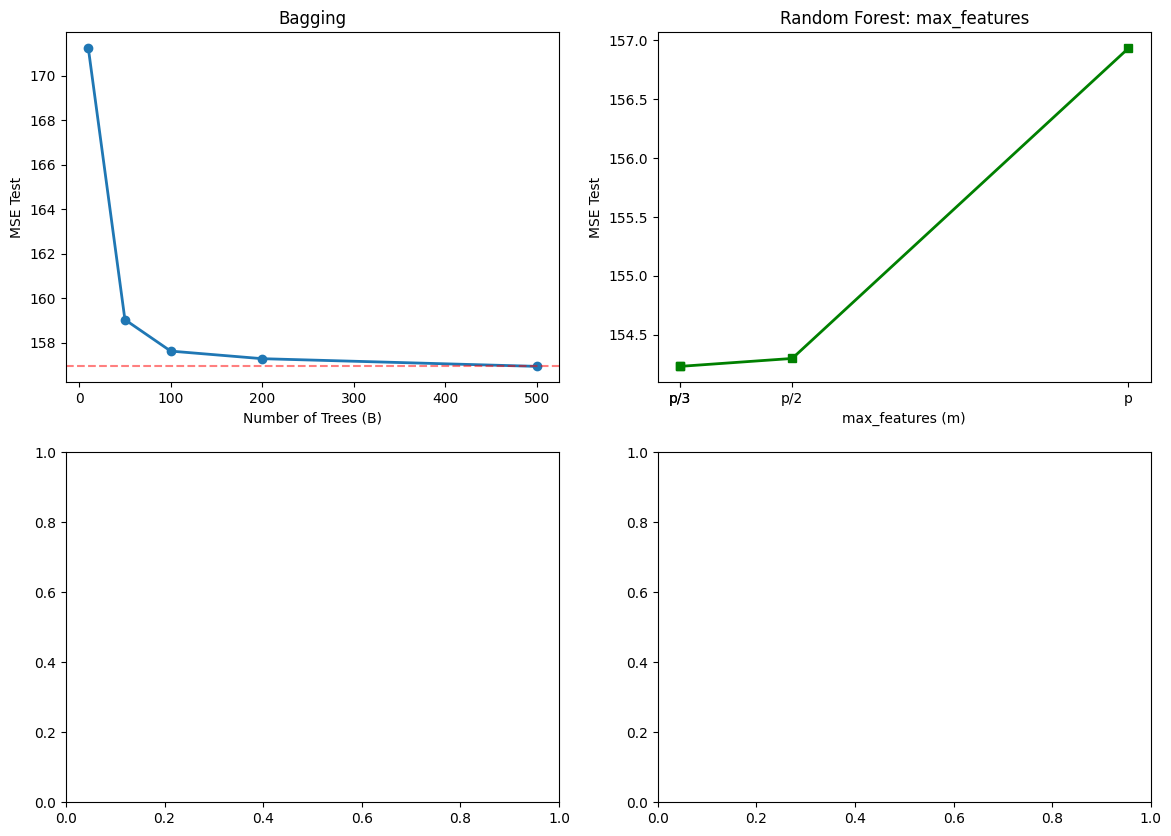

In [47]:
# Figure 2: Comparaison Bagging vs Random Forest vs Boosting
fig, axes = subplots(2, 2, figsize=(14, 10))

# Bagging
axes[0, 0].plot(n_trees_list, bagging_mse_test, marker='o', lw=2)
axes[0, 0].set_xlabel('Number of Trees (B)')
axes[0, 0].set_ylabel('MSE Test')
axes[0, 0].set_title('Bagging')
axes[0, 0].axhline(min(bagging_mse_test), color='red', linestyle='--', alpha=0.5)

# Random Forest - max_features
axes[0, 1].plot(m_values, rf_mse_test, marker='s', color='green', lw=2)
axes[0, 1].set_xlabel('max_features (m)')
axes[0, 1].set_ylabel('MSE Test')
axes[0, 1].set_title('Random Forest: max_features')
axes[0, 1].set_xticks(m_values)
axes[0, 1].set_xticklabels(m_labels)

# Random Forest - nombre d'arbres
axes[1, 0].plot(n_trees_list_rf, rf_ntrees_mse_test, marker='o', color='orange', lw=2)
axes[1, 0].set_xlabel('Number of Trees (B)')
axes[1, 0].set_ylabel('MSE Test')
axes[1, 0].set_title(f'Random Forest (m={best_m})')
axes[1, 0].axhline(min(rf_ntrees_mse_test), color='red', linestyle='--', alpha=0.5)

# Boosting
axes[1, 1].plot(n_trees_boost, boost_train_errors, marker='o', label='Train', lw=2)
axes[1, 1].plot(n_trees_boost, boost_ntrees_mse_test, marker='s', label='Test', lw=2)
axes[1, 1].set_xlabel('Number of Trees (B)')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].set_title(f'Boosting (depth={best_depth}, λ={best_lambda})')
axes[1, 1].legend()

fig.tight_layout()
plt.show()

NameError: name 'rf_importance' is not defined

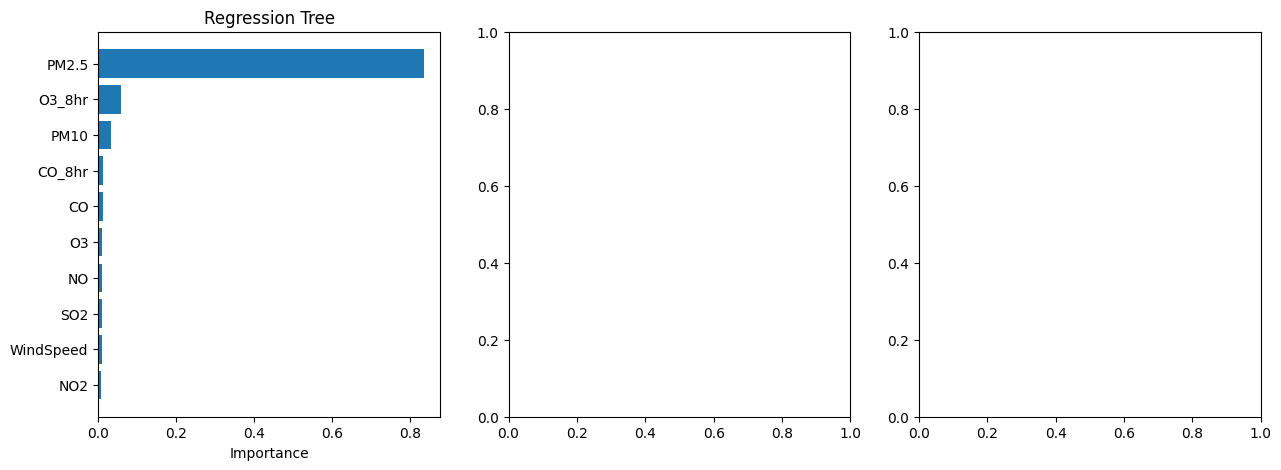

In [48]:
# Figure 3: Variable Importance Comparison
fig, axes = subplots(1, 3, figsize=(15, 5))

# Tree
axes[0].barh(feature_importance['Variable'].head(10), 
             feature_importance['Importance'].head(10))
axes[0].set_xlabel('Importance')
axes[0].set_title('Regression Tree')
axes[0].invert_yaxis()

# Random Forest
axes[1].barh(rf_importance['Variable'].head(10), 
             rf_importance['Importance'].head(10), color='green')
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest')
axes[1].invert_yaxis()

# Boosting
axes[2].barh(boost_importance['Variable'].head(10), 
             boost_importance['Importance'].head(10), color='orange')
axes[2].set_xlabel('Importance')
axes[2].set_title('Boosting')
axes[2].invert_yaxis()

fig.tight_layout()
plt.show()

In [39]:
# Figure 4: Visualization de l'arbre pruned (si pas trop grand)
if tree_pruned.get_n_leaves() <= 20:
    fig, ax = subplots(figsize=(20, 10))
    plot_tree(tree_pruned, 
              feature_names=key_features,
              filled=True,
              rounded=True,
              fontsize=10,
              ax=ax)
    ax.set_title('Pruned Regression Tree')
    plt.show()
else:
    print(f"\nArbre trop grand pour être visualisé ({tree_pruned.get_n_leaves()} feuilles)")



Arbre trop grand pour être visualisé (3674 feuilles)


In [ ]:
### COMPARAISON 